This script is a simple example of spatializing tabular data for use in mapping.


Install all necessary packages

In [1]:
!pip install pandas geopandas numpy matplotlib seaborn descartes bokeh pyreadr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.8/434.8 kB 7.2 MB/s eta 0:00:00


Load the necessary packages

In [2]:
import os
import pandas as pd
import numpy as np
import descartes
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable
from bokeh.plotting import figure, save, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper, ColorBar
from bokeh.palettes import Viridis256 as palette
from bokeh.io import output_notebook
import pyreadr
from functools import reduce
import matplotlib.pyplot as plt

Read in the 2019 county shapefile obtained from
https://www.census.gov/cgi-bin/geo/shapefiles/index.php


In [3]:
mkdir shapefiles

In [4]:
cd shapefiles

/content/shapefiles


In [5]:
os.system("curl -sS https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip > file.zip")

0

In [6]:
os.system("unzip file.zip")

0

In [7]:
rm file.zip

Let’s read the shapefile:

In [8]:
us_county_geo = geopandas.read_file('tl_2019_us_county.shp')

In [9]:
us_county_geo.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,NaN,NaN,NaN,A,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,NaN,NaN,NaN,A,680962890,61582307,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,NaN,NaN,NaN,A,6016819475,29089486,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,NaN,A,2169270569,22849484,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,NaN,NaN,NaN,A,1489645188,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


Read in the tabular data, which is an annual average of daily Tmax
(maximum air temperature in deg. C) for 2020 by county. Now let's read in the .Rds file:

In [10]:
tempobj = pyreadr.read_r('../Mean_Tmax_2020_Counties_CONUS.Rds') # also works for RData
# done!
# result is a dictionary where keys are the name of objects and the values python
# objects. In the case of Rds there is only one object with None as key
temp = tempobj[None] # extract the pandas data frame

In [11]:
temp.head()

,GEOID,MeanTmaxC
0,01001,24.246093
1,01003,24.257596
2,01005,24.859754
3,01007,23.533852
4,01009,22.180164


In [12]:
# Note that two counties are expected to have missing temperature data due to
# unavailability of data for these locations in the ERA5-Land input data set

len(temp[temp["MeanTmaxC"].isna() == True],) # 2


2

In [13]:
# Confirm that the GEOID variables in the table and shapefile are the same type
# and have leading 0's (counties with state FIPS < 10 have leading 0 that gets
# dropped when converting to numeric)

# Way 1 to confirm the GEOID variable is a string
def is_string(x):
    return isinstance(x, str)

is_string_series = us_county_geo['GEOID'].apply(is_string)
if is_string_series.all():
    print('The column is string data')
else:
    print('The column is not only string data')

# Way 2 to confirm the GEOID variable is a string
print(us_county_geo["GEOID"].dtypes)

The column is string data
object


In [14]:
geo_count = us_county_geo["GEOID"].map(lambda x: len(x)) # all values are 5 characters long, as expected
geo_count.value_counts()

5    3233
Name: GEOID, dtype: int64

In [15]:
# Way 1 to confirm the GEOID variable is a string
def is_string(x):
    return isinstance(x, str)

is_string_series = temp['GEOID'].apply(is_string)
if is_string_series.all():
    print('The column is string data')
else:
    print('The column is not only string data')

# Way 2 to confirm the GEOID variable is a string
print(temp["GEOID"].dtypes)

The column is string data
object


In [16]:
temp_count = temp["GEOID"].map(lambda x: len(x)) # all values are 5 characters long, as expected
temp_count.value_counts()

5    3108
Name: GEOID, dtype: int64

Merge the tabular data into the county shapefile by GEOID


In [17]:
# Merge the tabular data into the county shapefile by GEOID

data_frames = [us_county_geo, temp]
final = reduce(lambda left,right: pd.merge(left,right,on=['GEOID'], how='outer'), data_frames)

In [18]:
# Compare the dimensions of the input and output objects

print(len(us_county_geo))
print(len(temp))
print(len(final))

3233
3108
3233


In [19]:
# The county shapefile includes counties in AK, HI, PR, and other American island
# territories; the temperature data is only for CONUS and is missing for 2 counties
#
# We don't need a shapefile with missing data, so let's re-merge to keep only the
# matching values

final = reduce(lambda left,right: pd.merge(left,right,on=['GEOID'], how='inner'), data_frames)

In [20]:
# Compare the dimensions of the input and output objects

print(len(us_county_geo))
print(len(temp))
print(len(final))

3233
3108
3108


In [21]:
final.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,MeanTmaxC
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,NaN,NaN,NaN,A,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",16.222869
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,NaN,NaN,NaN,A,680962890,61582307,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2...",14.529672
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,NaN,NaN,NaN,A,6016819475,29089486,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9...",24.213415
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,NaN,A,2169270569,22849484,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790...",17.404317
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,NaN,NaN,NaN,A,1489645188,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089...",18.419126


In [22]:
# A lot of these census shapefile variables are useless; drop them

final = final.drop(["COUNTYNS", "NAME", "LSAD", "CLASSFP", "MTFCC", "CSAFP", "METDIVFP",
         "FUNCSTAT"], axis=1)

In [23]:
final.head()

,STATEFP,COUNTYFP,GEOID,NAMELSAD,CBSAFP,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,MeanTmaxC
0,31,039,31039,Cuming County,NaN,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",16.222869
1,53,069,53069,Wahkiakum County,NaN,680962890,61582307,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2...",14.529672
2,35,011,35011,De Baca County,NaN,6016819475,29089486,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9...",24.213415
3,31,109,31109,Lancaster County,30700,2169270569,22849484,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790...",17.404317
4,31,129,31129,Nuckolls County,NaN,1489645188,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089...",18.419126


In [24]:
# Confirm that all variable names are 10 characters or fewer
# (shapefile variable names are limited to 10 characters)

count = 0
names = {}
for name in final.columns:
  if len(name) > 10:
    count = count + 1
    names.append(name)

print(count)
print(names)

0
{}


In [25]:
# Confirm it has a coordinate reference system (CRS)

print(us_county_geo.crs)

# yes, it was inherited from the original census shapefile. Confirm:
print(final.crs)

print(us_county_geo.crs == final.crs)


EPSG:4269
EPSG:4269
True


Let’s create a static choropleth map for Annual average of daily maximum air temperature in deg. C for 2020 by county using the Matplotlib module:

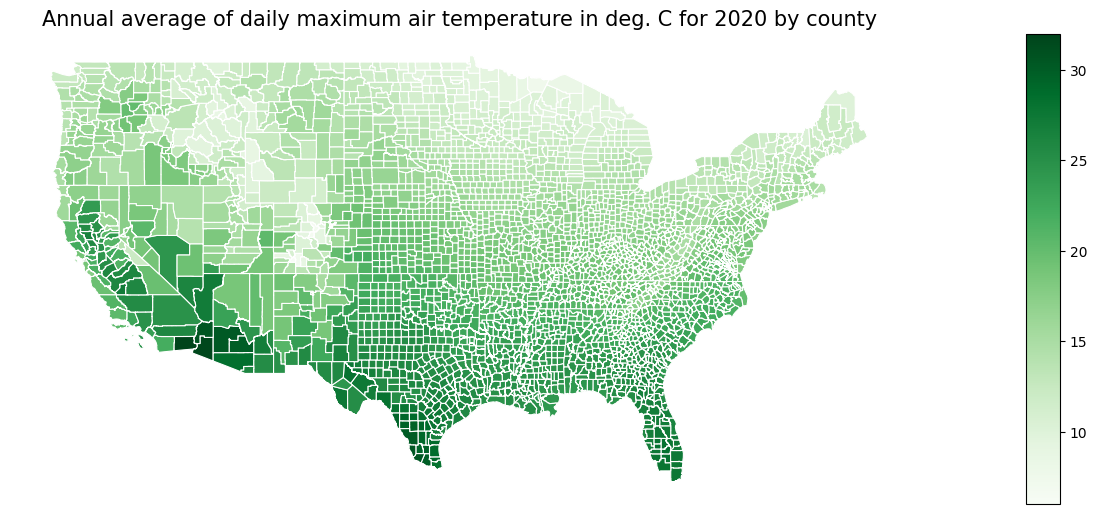

In [26]:
# set the value column that will be visualised
variable = 'MeanTmaxC'
# set the range for the choropleth values
vmin, vmax = int(round(min(final["MeanTmaxC"]))), int(round(max(final["MeanTmaxC"])))
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 15))
# remove the axis
ax.axis('off')
# add a title and annotation
ax.set_title('Annual average of daily maximum air temperature in deg. C for 2020 by county', fontdict={'fontsize': '15', 'fontweight' : '3'})

# create an axes on the right side of ax. The width of cax will be 3% of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

# Create colorbar legend
legend = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
legend.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(legend, cax=cax)

# create map

final.plot(column=variable, cmap='Greens', linewidth=0.8, ax=ax, cax=cax, edgecolor='1.0')

plt.show()

Interactive map - can be viewed in a browser

In [27]:
# Firstly, we need to create a function to get the polygon x and y coordinates:

def getPolyCoords(row, geom, coord_type):
    """Returns the coordinates ('x|y') of edges/vertices of a Polygon/others"""

    # Parse the geometries and grab the coordinate
    geometry = row[geom]
    #print(geometry.type)

    if geometry.geom_type=='Polygon':
        if coord_type == 'x':
            # Get the x coordinates of the exterior
            # Interior is more complex: xxx.interiors[0].coords.xy[0]
            return list( geometry.exterior.coords.xy[0] )
        elif coord_type == 'y':
            # Get the y coordinates of the exterior
            return list( geometry.exterior.coords.xy[1] )

    if geometry.geom_type in ['Point', 'LineString']:
        if coord_type == 'x':
            return list( geometry.xy[0] )
        elif coord_type == 'y':
            return list( geometry.xy[1] )

    if geometry.geom_type=='MultiLineString':
        all_xy = []
        for ea in geometry.geoms:
            if coord_type == 'x':
                all_xy.extend(list( ea.xy[0] ))
            elif coord_type == 'y':
                all_xy.extend(list( ea.xy[1] ))
        return all_xy

    if geometry.geom_type=='MultiPolygon':
        all_xy = []
        for ea in geometry.geoms:
            if coord_type == 'x':
                all_xy.extend(list( ea.exterior.coords.xy[0] ))
            elif coord_type == 'y':
                all_xy.extend(list( ea.exterior.coords.xy[1] ))
        return all_xy

    else:
        # Finally, return empty list for unknown geometries
        return []

In [28]:
# use our function to get the Polygon x and y coordinates
final['x'] = final.apply(getPolyCoords, geom='geometry', coord_type='x', axis=1)
final['y'] = final.apply(getPolyCoords, geom='geometry', coord_type='y', axis=1)
# show only head of x and y columns
final[['x', 'y']].head(2)

,x,y
0,"[-97.019516, -97.019519, -97.019527, -97.01952...","[42.004097, 42.004933, 42.007501, 42.009755, 4..."
1,"[-123.436394, -123.447592, -123.448042, -123.4...","[46.238197, 46.249832, 46.249932, 46.250831999..."


In [29]:
final.head()

,STATEFP,COUNTYFP,GEOID,NAMELSAD,CBSAFP,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,MeanTmaxC,x,y
0,31,039,31039,Cuming County,NaN,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",16.222869,"[-97.019516, -97.019519, -97.019527, -97.01952...","[42.004097, 42.004933, 42.007501, 42.009755, 4..."
1,53,069,53069,Wahkiakum County,NaN,680962890,61582307,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2...",14.529672,"[-123.436394, -123.447592, -123.448042, -123.4...","[46.238197, 46.249832, 46.249932, 46.250831999..."
2,35,011,35011,De Baca County,NaN,6016819475,29089486,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9...",24.213415,"[-104.567387, -104.567717, -104.567924, -104.5...","[33.997566, 33.997569999999996, 33.99757299999..."
3,31,109,31109,Lancaster County,30700,2169270569,22849484,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790...",17.404317,"[-96.91075099999999, -96.910753, -96.910753, -...","[40.784943999999996, 40.790393, 40.790486, 40...."
4,31,129,31129,Nuckolls County,NaN,1489645188,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089...",18.419126,"[-98.27366699999999, -98.27366699999999, -98.2...","[40.089399, 40.089411, 40.090402, 40.090722, 4..."


In [30]:
# make a copy, drop the geometry column and create ColumnDataSource

final_df = final.drop('geometry', axis=1).copy()
gsource = ColumnDataSource(final_df)

Building a simple interactive map

In [ ]:
# create the color mapper
color_mapper = LogColorMapper(palette=palette)
# initialize our figure
p = figure(title="Annual average of daily maximum air temperature in deg. C for 2020 by county", width=1200, height=800)
# Plot grid
p.patches('x', 'y', source=gsource, fill_color={'field': 'MeanTmaxC', 'transform': color_mapper}, fill_alpha=1.0, line_color="black", line_width=0.05)
# create a color bar
color_bar = ColorBar(color_mapper=color_mapper, width=16,  location=(0,0))
# add color bar to map
p.add_layout(color_bar, 'right')
# initialize our tool for interactivity to the map
my_hover = HoverTool()
# tell to the HoverTool that what information it should show to us
my_hover.tooltips = [('name', '@NAMELSAD'), ('temperature', '@MeanTmaxC')]
# add this new tool into our current map
p.add_tools(my_hover)
# save the map
output_file("../Mean_Tmax_2020_Counties_CONUS_map_hover.html")
save(p)


'/content/Mean_Tmax_2020_Counties_CONUS_map_hover.html'